# Task 3: Modular Neural Network
# CENG501 - Spring 2023 - PA1

In this task, you will implement a fully-connected neural network (a.k.a. multi-layer perceptron) in a modular manner. We will define a class for the different components of a neural network: One for a linear (fully connected) layer, one for activation function and one for loss function.

*Disclaimer: Some components are adapted or taken from [CS231n](https://cs231n.github.io/) materials.*

## 1 Import the Modules

Let us start with importing some libraries that we will use throughout the task.

In [1]:
import matplotlib.pyplot as plt # For plotting
import numpy as np              # NumPy, for working with arrays/tensors 
import os                       # Built-in library for filesystem access etc.
import pickle                   # For (re)storing Python objects into (from) files 
import time                     # For measuring time

%matplotlib inline
plt.rcParams['figure.figsize'] = [12, 8]
plt.rcParams['figure.dpi'] = 100 # 200 e.g. is really fine, but slower

## 2 The Dataset

Like Task 1 and 2, we will use the [CIFAR-10](https://www.cs.toronto.edu/~kriz/cifar.html) dataset. In this task, we will directly load and continue with preprocessing steps. Please see Task 1 for more details about the dataset. 

### 2.1 Download the Dataset


In [2]:
# Download the file
! wget https://www.cs.toronto.edu/~kriz/cifar-10-python.tar.gz

# Extract the compressed file
! tar zxvf cifar-10-python.tar.gz

--2023-04-12 18:00:02--  https://www.cs.toronto.edu/~kriz/cifar-10-python.tar.gz
Resolving www.cs.toronto.edu (www.cs.toronto.edu)... 128.100.3.30
Connecting to www.cs.toronto.edu (www.cs.toronto.edu)|128.100.3.30|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 170498071 (163M) [application/x-gzip]
Saving to: ‘cifar-10-python.tar.gz’

cifar-10-python.tar 100%[===================>] 162.60M  30.6MB/s    in 5.9s    

2023-04-12 18:00:09 (27.7 MB/s) - ‘cifar-10-python.tar.gz’ saved [170498071/170498071]

cifar-10-batches-py/
cifar-10-batches-py/data_batch_4
cifar-10-batches-py/readme.html
cifar-10-batches-py/test_batch
cifar-10-batches-py/data_batch_3
cifar-10-batches-py/batches.meta
cifar-10-batches-py/data_batch_2
cifar-10-batches-py/data_batch_5
cifar-10-batches-py/data_batch_1


### 2.2 Load the Dataset

*Disclaimer: This loader is adapted from [CS231n](https://cs231n.github.io/) materials.*

In [3]:
def load_CIFAR_batch(filename):
  """ load single batch of cifar """
  with open(filename, 'rb') as f:
    datadict = pickle.load(f, encoding='latin1')
    X = datadict['data']
    Y = datadict['labels']
    X = X.reshape(10000, 3, 32, 32).transpose(0,2,3,1).astype("float")
    Y = np.array(Y)
    return X, Y

def load_CIFAR10(ROOT):
  """ load all of cifar """
  xs = []
  ys = []
  for b in range(1,6):
    f = os.path.join(ROOT, 'data_batch_%d' % (b, ))
    X, Y = load_CIFAR_batch(f)
    xs.append(X)
    ys.append(Y)    
  Xtr = np.concatenate(xs)
  Ytr = np.concatenate(ys)
  del X, Y
  Xte, Yte = load_CIFAR_batch(os.path.join(ROOT, 'test_batch'))
  return Xtr, Ytr, Xte, Yte

def get_CIFAR10_data(cifar10_dir, num_training=49000, num_validation=1000, num_test=1000):
    """
    Load the CIFAR-10 dataset from disk and perform preprocessing to prepare
    it for classifiers. These are the same steps as we used for the SVM, but
    condensed to a single function.
    """
    # Load the raw CIFAR-10 data
    X_train, y_train, X_test, y_test = load_CIFAR10(cifar10_dir)
        
    # Subsample the data
    mask = range(num_training, num_training + num_validation)
    X_val = X_train[mask]
    y_val = y_train[mask]
    mask = range(num_training)
    X_train = X_train[mask]
    y_train = y_train[mask]
    mask = range(num_test)
    X_test = X_test[mask]
    y_test = y_test[mask]

    return X_train, y_train, X_val, y_val, X_test, y_test

# Now use these functions to load the dataset:
X_train, y_train, X_val, y_val, X_test, y_test = get_CIFAR10_data('cifar-10-batches-py/')

X_train = np.reshape(X_train, (X_train.shape[0], -1))
X_val = np.reshape(X_val, (X_val.shape[0], -1))
X_test = np.reshape(X_test, (X_test.shape[0], -1))

# Note that 32x32x3 = 3072
print('Training data shape: ', X_train.shape)
print('Training labels shape: ', y_train.shape)
print('Test data shape: ', X_test.shape)
print('Test labels shape: ', y_test.shape)

Training data shape:  (49000, 3072)
Training labels shape:  (49000,)
Test data shape:  (1000, 3072)
Test labels shape:  (1000,)


### 2.3 Preprocessing

We will perform two preprocessing steps: Subtracting the mean and adding a bias dimension to the inputs to make things easier for calculations on the weight matrix.

*Disclaimer: This step is taken from [CS231n](https://cs231n.github.io/) materials.*

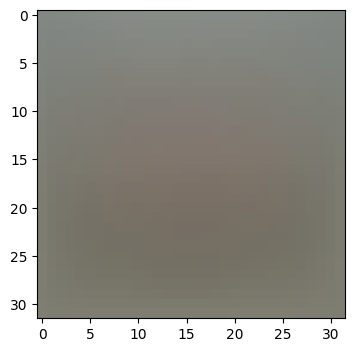

In [4]:
# Preprocessing: subtract the mean image
# first: compute the image mean based on the training data
mean_image = np.mean(X_train, axis=0)
plt.figure(figsize=(4,4))
plt.imshow(mean_image.reshape((32,32,3)).astype('uint8')) # visualize the mean image
plt.show()

# second: subtract the mean image from train and test data
X_train -= mean_image
X_test -= mean_image
X_val -= mean_image

In [5]:
# third: append the bias dimension of ones (i.e. bias trick) so that our SVM
# only has to worry about optimizing a single weight matrix W.
X_train = np.hstack([X_train, np.ones((X_train.shape[0], 1))])
X_val = np.hstack([X_val, np.ones((X_val.shape[0], 1))])
X_test = np.hstack([X_test, np.ones((X_test.shape[0], 1))])

print('Training data shape: ', X_train.shape)
print('Validation data shape: ', X_val.shape)
print('Test data shape: ', X_test.shape)

Training data shape:  (49000, 3073)
Validation data shape:  (1000, 3073)
Test data shape:  (1000, 3073)


## 3 Building Blocks

In this task, we will take a modular approach and define a class for different components of a neural network: One for a linear (fully connected) layer, one for activation functions and one for loss functions.

The goal is to have a usage that we find in high-level frameworks like Pytorch or Keras. Here is an example (which is actually what we will use in Section 4.1):

```python
class MyModel:
  def __init__(self, D, H, C, reg=1e-5):
    self.fc1 = LinearLayer(D, H, reg)
    self.sigma1 = ReLU()
    self.fc2 = LinearLayer(H, C, reg)

  def __call__(self, X):
    return self.forward(X)
    
  def forward(self, X):
    X = self.fc1(X)
    X = self.sigma1(X)
    X = self.fc2(X)

    return X
```

### 3.1 Linear Layer

As we have seen before, a linear layer simply performs the following linear operation (note that $\mathbf{x}$ contains a constant 1 for the bias):
$$
f(\mathbf{x}; W) = W\cdot \mathbf{x}. 
$$




In [6]:
class LinearLayer:
  def __init__(self, in_dim, out_dim, reg=1e-5):
    """Initialize the linear layer. Weights are randomly initialized in a small range.

      in_dim: The dimensionality of input (a single instance). 
      out_dim: The dimensionality of the output (a single instance).
    """
    self.in_dim = in_dim
    self.out_dim = out_dim
    self.reg = reg
    self.inp = None
    np.random.seed(501) # for reproducibility, set the seed to a constant
    self.W = 0.001 * np.random.randn(in_dim, out_dim)

  def __call__(self, inp):
    """This is needed to be able to use the object like a function. The task
      is handled by the forward function. 
      
      inp: a Numpy array or another module object (layer or non-linearity)
    """
    return self.forward(inp)

  def forward(self, inp):
    """Feedforward processing through the layer. Fill in self.out with the scores.
      
      inp: a Numpy array or another module object (layer or non-linearity)
      Return: The object itself.
    """
    self.inp = inp  # save input object for backprop() and update()

    # if the input is not a Numpy array, access its Numpy.array element inp.out
    self.X = inp.out if type(inp) is not np.ndarray else inp
    self.N = self.X.shape[0] # We will need this in backprop

    self.out = None
    ##########################################################################
    # @TODO: Calculate the linear transformation and store the result in     # 
    #  self.out.                                                             #
    ##########################################################################
    self.out = np.dot(self.X, self.W)
    ##########################################################################
    #                       END OF YOUR CODE                                 #
    ##########################################################################

    return self # Return the object to make it easier to feedforward across layers

  def backprop(self, in_grad):
    """Backpropagate through the layer. Calculate self.dW given incoming 
       gradient and calculate out_grad. Pass out_grad to the earlier module 
       via self.inp.backprop(out_grad).

      in_grad: The derivative of the loss wrt. the output of the layer.
    """
    out_grad = None
    self.dW = None
    ###########################################################################
    # @TODO: Calculate self.dW with in_grad. Add weight-decay owing to the    #
    # regularization on W. Calculate out_grad that will be passed down to the #
    # earlier layer/module.                                                   #
    ###########################################################################
    self.dW = np.dot(self.X.T, in_grad) + self.reg * self.W
    out_grad = np.dot(in_grad, self.W.T)
    ###########################################################################
    #                       END OF YOUR CODE                                  #
    ###########################################################################
    if type(self.inp) is not np.ndarray: self.inp.backprop(out_grad)

  def update(self, learning_rate):
    """Update the weights and initiate the update of the incoming module.
       
       learning_rate: The learning rate.
    """
    #########################################################################
    # @TODO: This part will look very similar to what you did in Task 1.    #
    #########################################################################
    self.W -= learning_rate * self.dW
    #########################################################################
    #                       END OF YOUR CODE                                #
    #########################################################################
    self.inp.update(learning_rate) if type(self.inp) is not np.ndarray else None


### 3.2 Activation Function

We will implement the ReLU [1] nonlinearity:

$$
\textrm{ReLU}(s) = \max(0, s),
$$

where $s$ is generally the output of a linear layer, e.g. $\textbf{w}\cdot \textbf{x}$. I implemented the `forward()` function below and left the `backprop()` function to you.

[1] Krizhevsky, A., Sutskever, I., & Hinton, G. E. (2012). Imagenet classification with deep convolutional neural networks. Advances in neural information processing systems, 25, 1097-1105. [[PDF](http://www.cs.toronto.edu/~fritz/absps/imagenet.pdf)]

In [7]:
class ReLU:
  def __init__(self):
    """Initialize ReLU."""
    self.inp = None

  def __call__(self, inp):
    """This is needed to be able to use the object like a function. The task
      is handled by the forward function. 
      
      inp: a Numpy array or another module object (layer or non-linearity)
    """
    return self.forward(inp)

  def forward(self, inp):
    """Feedforward processing through ReLU.
      
      inp: a Numpy array or another module object (layer or non-linearity)
      Return: The object itself.
    """
    self.inp = inp # save input object for backprop() and update()

    # Feedforward
    self.out = np.maximum(0, inp.out)

    return self # Return the object. This makes it easier to pass things across layers

  def backprop(self, in_grad):
    """Backpropagate through the layer. Calculate self.dX given incoming 
       gradient and calculate out_grad. Pass out_grad to the earlier module 
       via self.inp.backprop(out_grad).

      in_grad: The derivative of the loss wrt. the output of the module.
    """
    out_grad = None
      
    ###########################################################################
    # @TODO: Calculate out_grad that will be passed down                      #
    #  to the earlier layer/module.                                           #
    ###########################################################################
    out_grad = in_grad * (self.inp.out > 0)
    ##########################################################################
    #                       END OF YOUR CODE                                 #
    ##########################################################################
    self.inp.backprop(out_grad)

  def update(self, learning_rate):
    """Relay the update message to the earlier module. Nothing to update in ReLU.
       
       learning_rate: The learning rate.
    """
    self.inp.update(learning_rate) if type(self.inp) is not np.ndarray else None

### 3.2 Loss Function

We will now implement cross-entropy loss which internally applies softmax on the score predictions provided as input. Let us recall the loss function from Task 2:
$$
L = \frac{1}{N} \sum_{i=1}^N - \log(p_{y_i}),
$$
where $p_{y_i} = sm(s_{y_i})$ is the prediction probability for the correct class for sample $\mathbf{x}_i$. Note that this time we don't have regularization implemented as part of the loss function -- it was implemented as weight decay in the `LinearModel` above.


In [8]:
class CrossEntropyLoss:
  def __init__(self):
    """Initialize the loss module."""
    self.pred = None

  def __call__(self, pred, target):
    """This is needed to be able to use the object like a function. The task
      is handled by the forward function. 
      
      pred: A module object (layer or non-linearity)
      target: Numpy array storing the correct/target values.
    """
    return self.forward(pred, target)

  def forward(self, pred, target):
    """Feedforward processing through the loss.
      
      pred: A module object (layer or non-linearity). Assumed to be scores.
      target: Numpy array storing the correct/target values.
      Returns: The scalar loss value.
    """
    self.pred = pred # save input object for later use
    self.target = target # save target for later use
    self.scores = pred.out # get the scores from the input object
    self.N = self.scores.shape[0] 

    self.probs = None # Save calculated probabilities into this
    loss = None # Save calculated loss into this
    ###########################################################################
    # @TODO: (i) Convert scores to probabilities and save it in self.probs    #
    #        (ii) Calculate Cross-entropy loss. Note that this will be a      #
    #             scalar.                                                     #
    #   Don't add weight regularization here. We implement it directly as     #
    #   weight decay. Don't forget to normalize the loss.                     #
    ###########################################################################
    # (i) Convert scores to probabilities and save it in self.probs
    self.probs = np.exp(self.scores) / np.sum(np.exp(self.scores), axis=1, keepdims=True)
    # (ii) Calculate Cross-entropy loss. Note that this will be a scalar.
    loss = -np.sum(np.log(self.probs[np.arange(self.N), self.target])) / self.N
    ##########################################################################
    #                       END OF YOUR CODE                                 #
    ##########################################################################
   
    return loss

  def backprop(self):
    """Start backpropagate with this loss definition. Calculate the derivative
       wrt. the scores and pass that to the earlier module 
       via self.inp.backprop(self.dscores).
    """
    self.dscores = None # Calculate and save the derivative wrt the scores here
    ###########################################################################
    # @TODO: Calculate self.dscores. Don't forget to normalize the gradient.  #
    ###########################################################################
    self.dscores = self.probs
    self.dscores[np.arange(self.N), self.target] -= 1
    self.dscores /= self.N
    ##########################################################################
    #                       END OF YOUR CODE                                 #
    ##########################################################################
  
    self.pred.backprop(self.dscores)

  def update(self, learning_rate):
    """Relay the update message to the earlier module. Nothing to update here.
       
       learning_rate: The learning rate.
    """
    self.pred.update(learning_rate) if type(self.pred) is not np.ndarray else None

### 3.3 Training Method

Okay, it seems that we have most of the ingredients ready, except for a few things. Go back to the implementation of the `LinearModel` and complete the `update()` function. Then come back here and define the train function (just click run).

In [9]:
def sample_batch(X, y, batch_size):
  """Get a random batch of size batch_size from (X, y)."""
  batch_indices = np.random.choice(range(X.shape[0]), size=batch_size)
  X_batch = X[batch_indices]
  y_batch = y[batch_indices]

  return X_batch, y_batch

def train(model, loss_fn, X, y, learning_rate=1e-3, epochs=10, batch_size=32, verbose=False):
  """
    Train this linear classifier using stochastic gradient descent.
    Inputs:
    - X: A numpy array of shape (N, D) containing training data; there are N
      training samples each of dimension D.
    - y: A numpy array of shape (N,) containing training labels; y[i] = c
      means that X[i] has label 0 <= c < C for C classes.
    - learning_rate: (float) learning rate for optimization.
    - reg: (float) regularization strength.
    - num_iters: (integer) number of steps to take when optimizing
    - batch_size: (integer) number of training examples to use at each step.
    - verbose: (boolean) If true, print progress during optimization.
    Outputs:
    A list containing the value of the loss function at each training iteration.
  """
  N, D = X.shape

  # Run stochastic gradient descent to optimize W
  loss_history = []
  for epoch in range(epochs):
    for it in range(int(N/batch_size)): 
      
      # Get a batch of samples
      X_batch, y_batch = sample_batch(X, y, batch_size)

      # Feed-forward through the model
      preds = model(X_batch)

      # Calculate the loss
      loss = loss_fn(preds, y_batch)
      loss_history.append(loss)

      # Calculate the gradient
      loss_fn.backprop()

      # Perform parameter update
      loss_fn.update(learning_rate)

    if verbose: print(f'Epoch {epoch} / {epochs}: {loss}')
      
  return loss_history

## 4 Define and Train a Model

Now, all the pieces are ready and we can define a model.

### 4.1 Model Definition

Thanks to our modular definition, we can define models in a very simple manner as follows. Note that this is very similar to how you would define a model in PyTorch.

In [10]:
class MyModel:
  def __init__(self, D, H, C, reg=1e-5):
    self.fc1 = LinearLayer(D, H, reg)
    self.sigma1 = ReLU()
    self.fc2 = LinearLayer(H, C, reg)

  def __call__(self, X):
    return self.forward(X)
    
  def forward(self, X):
    X = self.fc1(X)
    X = self.sigma1(X)
    X = self.fc2(X)

    return X

### 4.2 Check Gradients

Let us check whether our gradients are correct. Again, you should see very low differences (< $10^{-8}$)

In [11]:
from random import randrange

def grad_check_sparse(f, x, analytic_grad, num_checks=10, h=1e-5):
  """
  sample a few random elements and only return numerical
  in these dimensions.
  """

  for i in range(num_checks):
    ix = tuple([randrange(m) for m in x.shape])
    oldval = x[ix]

    x[ix] = oldval + h # increment a single dimension of x (W) by h
    fxph = f(x) # evaluate f(x + h)

    x[ix] = oldval - h # decrement by h
    fxmh = f(x) # evaluate f(x - h)
    
    x[ix] = oldval # reset

    grad_numerical = (fxph - fxmh) / (2 * h)
    grad_analytic = analytic_grad[ix]
    rel_error = abs(grad_numerical - grad_analytic) / (abs(grad_numerical) + abs(grad_analytic))
    print('numerical: %f analytic: %f, relative error: %e' % (grad_numerical, grad_analytic, rel_error))

def f(W): 
  out = model(X_val)
  return loss_fn(out, y_val) #W, scores, y):

D = X_val.shape[1]
C = np.max(y_val) + 1
H = 20 # Number of hidden neurons

# Create 
model = MyModel(D, H, C, reg=0) #5e-6)
loss_fn = CrossEntropyLoss()

print("======= ERRORS FOR THE GRADIENTS OF THE FIRST LAYER ==========")
preds = model(X_val)
loss_fn(preds, y_val)
loss_fn.backprop()
grad_numerical = grad_check_sparse(f, x=model.fc1.W, analytic_grad=model.fc1.dW, num_checks=10)

print("======= ERRORS FOR THE GRADIENTS OF THE SECOND LAYER ==========")
preds = model(X_val)
loss_fn(preds, y_val)
loss_fn.backprop()
grad_numerical = grad_check_sparse(f, x=model.fc2.W, analytic_grad=model.fc2.dW, num_checks=10)

======= ERRORS FOR THE GRADIENTS OF THE FIRST LAYER ==========
numerical: 0.001500 analytic: 0.001500, relative error: 9.109569e-09
numerical: 0.003975 analytic: 0.003975, relative error: 2.532996e-09
numerical: 0.003751 analytic: 0.003751, relative error: 9.282867e-10
numerical: -0.000531 analytic: -0.000531, relative error: 1.333931e-08
numerical: 0.003498 analytic: 0.003498, relative error: 8.658801e-10
numerical: 0.003228 analytic: 0.003228, relative error: 4.306861e-09
numerical: -0.000089 analytic: -0.000089, relative error: 1.733290e-08
numerical: -0.002892 analytic: -0.002892, relative error: 2.545792e-09
numerical: -0.001274 analytic: -0.001274, relative error: 6.746361e-09
numerical: 0.001946 analytic: 0.001946, relative error: 8.843431e-09
======= ERRORS FOR THE GRADIENTS OF THE SECOND LAYER ==========
numerical: -0.019460 analytic: -0.019460, relative error: 1.419314e-09
numerical: -0.034786 analytic: -0.034786, relative error: 7.108187e-10
numerical: 0.011737 analytic: 0.0

### 4.3 Train the Model

In [12]:
N, D = X_train.shape
C = np.max(y_test) + 1 # assume y takes values 0...K-1 where K is number of classes
H = 200

model = MyModel(D, H, C, reg=1e-1)
loss_fn = CrossEntropyLoss()

loss_history = train(model, loss_fn, X_train, y_train, learning_rate=1e-4, epochs=10, batch_size=200, verbose=True)

Epoch 0 / 10: 1.9279166304787914
Epoch 1 / 10: 1.967456784188389
Epoch 2 / 10: 1.76148467004923
Epoch 3 / 10: 1.7993784140262072
Epoch 4 / 10: 1.6881149688859654
Epoch 5 / 10: 1.6408140230887336
Epoch 6 / 10: 1.617209391836735
Epoch 7 / 10: 1.5780015706796364
Epoch 8 / 10: 1.6351571000480882
Epoch 9 / 10: 1.512648213700299


## 5 Analyze Results

We have trained our model and now we should analyze how well it performed. We should look at several factors:

* The loss curve.
* Quantitative analysis of the performance.
* Visual analysis of the weights and the predictions.

### 5.1 The Loss Curve

One of the first things we should do when analyzing a model is to plot the loss curve. We should ideally see a smoothly decreasing curve over iterations/epochs.

While doing this, we should also plot the loss curve for the validation set and look for any signs of memorization. To keep things simple, we did not keep a history of validation losses. You can do this as a bonus (see the last item).

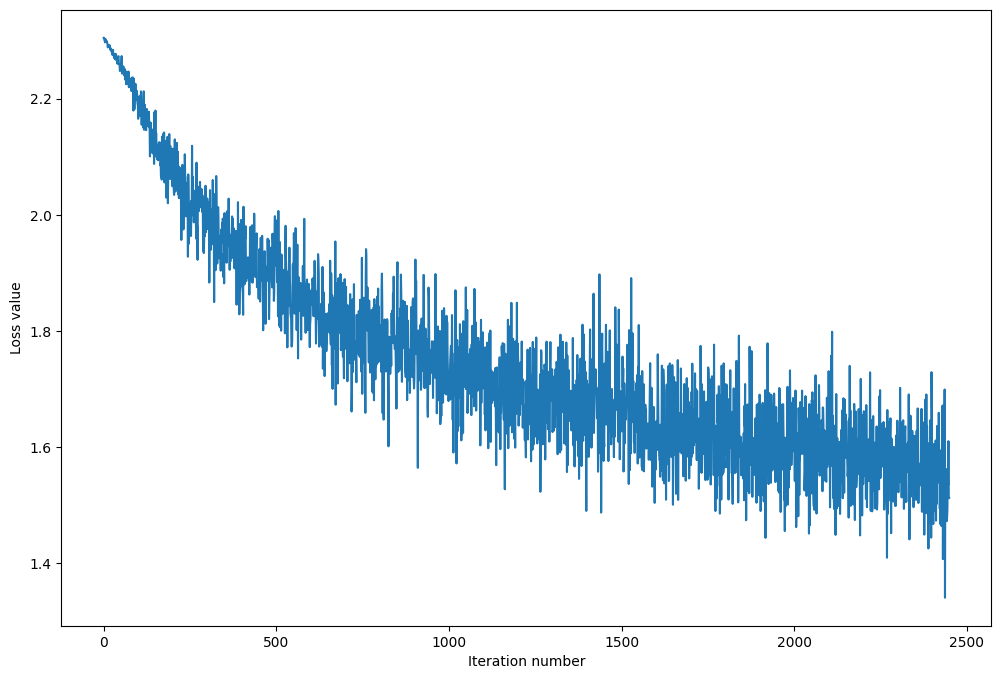

In [13]:
plt.plot(loss_history)
plt.xlabel('Iteration number')
plt.ylabel('Loss value')
plt.show()

### 5.2 Quantitative Analysis

We can analyze the accuracy of the predictions as follows. You should see around 45\%-46\% accuracies.

In [14]:
preds = model(X_train)
y_train_pred = np.argmax(preds.out, axis=1)
print('training accuracy: %f' % (np.mean(y_train == y_train_pred), ))

preds = model(X_val)
y_val_pred = np.argmax(preds.out, axis=1)
print('validation accuracy: %f' % (np.mean(y_val == y_val_pred), ))

training accuracy: 0.456408
validation accuracy: 0.465000


### 5.3 Visual Results

Let us look at some visual results. You should see that many of the predictions are off, as we should expect from low accuracy values. This is expected since a linear model is limited for such a classification problem.

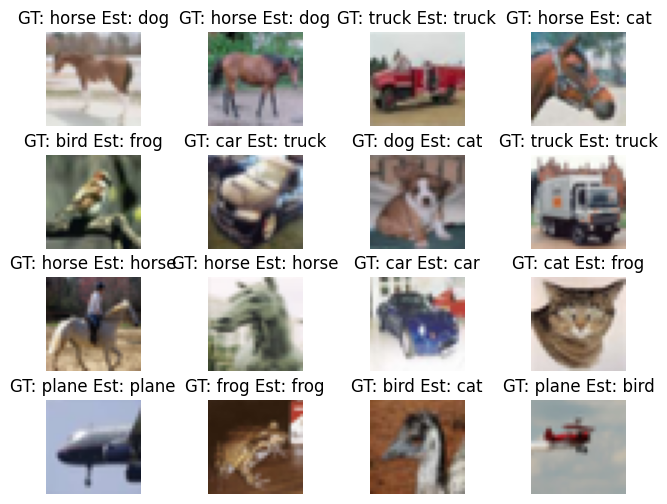

In [15]:
classes = ['plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']

S = 4 # SxS random samples will be selected and drawn

plt.rcParams['figure.figsize'] = [8, 6]

for i in range(S):
  for j in range(S):
    id = np.random.randint(y_test.shape[0])
    X = X_test[id]
    y = y_test[id]
    plt.subplot(S, S, i*S+j+1)
    plt.imshow((X[:-1]+mean_image).reshape(32,32,3).astype('uint8'))
    pred = np.argmax(model(X.reshape(1, 3073)).out)
    plt.axis('off')
    plt.title("GT: " + classes[y] + " Est: " + classes[pred])
    plt.subplots_adjust(hspace = 0.3)

plt.show()
plt.rcParams['figure.figsize'] = [6, 4]

### 5.4 Visualize Weights

Let us visualize the weights of the first layer. You should see some object-like templates being visible in the images, though they are noisy.

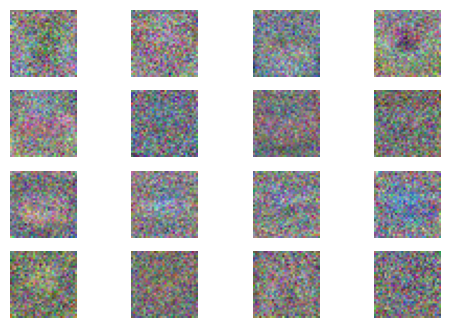

In [16]:
# Display weights of the first SxS neurons of the first layer
W1 = model.fc1.W[:-1,:] # strip out the bias
S = 4

for i in range(S):
  for j in range(S):
    w_ij = W1[:, i*S+j].reshape(32,32,3)
    wimg = 255.0 * (w_ij - np.min(w_ij)) / (np.max(w_ij) - np.min(w_ij))
    
    plt.subplot(S, S, i*S + j + 1)
    plt.imshow(wimg.astype('uint8'))
    plt.axis('off')

plt.show()


## 6 Tune your Model [Optional]

Like we did in Task 1, you can tune the hyperparameters for a range of learning rates, regularization strengths, number of neurons in the hidden layer etc. As tuning a two-layer NN takes longer, I leave this item optional.